## Source

Analysis and Scenario Development in Uganda’s Transport Sector  
- Private and public: Table 4-3, page 43.  
- Rail: Table 5-2, page 48.  
- Water: Table 6-2, page 52.  
- Aviation: Table 7-1, page 55.

### Aviation computation

Estimated Passenger-Kilometers (PKM) for International Aviation Departures in Uganda (2015–2018).

**Data Source:**  
* Number of domestic departing and arriving passengers per year (Table 7-1).  
* Number of international departing passengers per year (Table 7-1).  
* Assumption: Each international flight has an average travel distance of 2,500 km. And each domestic flight has an average travel distance of 300 km.

**Formula:**  
* PKM = Number of passengers × Average Distance per Departure (km)


In [1]:
import numpy as np
import pandas as pd
import os
from utils.utils import EDAUtils, TransportUtils, GeneralUtils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
edau = EDAUtils()
tu = TransportUtils()
gu = GeneralUtils()

In [4]:
# Set up paths
CURRENT_DIR_PATH = os.getcwd()
OUTPUT_DATA_DIR_PATH = os.path.join(CURRENT_DIR_PATH, "output_data")
INPUT_DATA_DIR_PATH = os.path.join(CURRENT_DIR_PATH, "input_data")

In [5]:
# Load population data
POPULATION_DATA_PATH = os.path.join(OUTPUT_DATA_DIR_PATH, "POPULATION.csv")
pop_df = pd.read_csv(POPULATION_DATA_PATH)

# Filter for the years 2015 to 2050
pop_df = pop_df[(pop_df['year'] >= 2015) & (pop_df['year'] <= 2050)]
pop_df = pop_df.reset_index(drop=True)
pop_df.head()

,year,population_gnrl_rural,population_gnrl_urban
0,2015,27415805,7922107
1,2016,28126956,8404570
2,2017,28903581,8925631
3,2018,29672226,9464281
4,2019,30457624,10028890


In [6]:
# Create pop_total column
pop_df['pop_total'] = pop_df['population_gnrl_rural'] + pop_df['population_gnrl_urban']
pop_df.head()

,year,population_gnrl_rural,population_gnrl_urban,pop_total
0,2015,27415805,7922107,35337912
1,2016,28126956,8404570,36531526
2,2017,28903581,8925631,37829212
3,2018,29672226,9464281,39136507
4,2019,30457624,10028890,40486514


In [7]:
pop_df.tail()

,year,population_gnrl_rural,population_gnrl_urban,pop_total
31,2046,38769171,28301495,67070666
32,2047,38877625,29165895,68043520
33,2048,38966634,30038289,69004923
34,2049,39030689,30913903,69944592
35,2050,39070478,31792509,70862987


In [8]:
# Keep only pop_total col
trde_passenger_df = pop_df[['year', 'pop_total']].copy()
trde_passenger_df.head()

,year,pop_total
0,2015,35337912
1,2016,36531526
2,2017,37829212
3,2018,39136507
4,2019,40486514


In [9]:
# Load gdp data
gdp_df = pd.read_csv(os.path.join(OUTPUT_DATA_DIR_PATH, "gdp_mmm_usd.csv"))
gdp_df.head()

,year,gdp_mmm_usd
0,1979,11.488563
1,1980,11.098871
2,1981,11.527176
3,1982,12.472981
4,1983,13.084033


In [10]:
trde_passenger_df = trde_passenger_df.merge(gdp_df[["year", "gdp_mmm_usd"]], on='year', how='left')
trde_passenger_df.head()

,year,pop_total,gdp_mmm_usd
0,2015,35337912,79.03
1,2016,36531526,82.81
2,2017,37829212,85.41
3,2018,39136507,90.79
4,2019,40486514,96.64


In [11]:
# raw inputs

# 2019 values
private_passenger_trde = 41.81e9
public_passenger_trde  = 69.36e9

rail_passenger_trde = {
    2016: 342_230,
    2017: 174_824,
    2018: 473_757,
    2019: 437_398,
    2020: 160_672,

}

inland_water_passenger_trde = 17_252_769 # 2019 value

# raw inputs
domestic_passengers_arrivals = {
    2015: 7634,
    2016: 7350,
    2017: 9539,
    2018: 13798,
    2019: 13798 # 2019 value assumed same as 2018
}

domestic_passengers_departures = {
    2015: 7300,
    2016: 6816,
    2017: 9285,
    2018: 12982,
    2019: 12982 # 2019 value assumed same as 2018
}

international_passengers_departures = {
    2015: 690962,
    2016: 703649,
    2017: 757360,
    2018: 849034,
    2019: 849034 # 2019 value assumed same as 2018
}

aviation_passenger_trde = tu.compute_passenger_km(domestic_passengers_arrivals, domestic_passengers_departures, international_passengers_departures)
aviation_passenger_trde

{2015: 1731885200,
 2016: 1763372300,
 2017: 1899047200,
 2018: 2130619000,
 2019: 2130619000}

In [12]:
base_year = 2019

# Get base population and PKMs
base_pop = trde_passenger_df.loc[trde_passenger_df['year'] == base_year, 'pop_total'].values[0]
base_private_pkms = private_passenger_trde
base_public_pkms = public_passenger_trde
base_regional_pkms = (
    rail_passenger_trde.get(base_year, 0)
    + inland_water_passenger_trde
    + aviation_passenger_trde.get(base_year, 0)
)

# Set GDP scaling factor
gdp_scaling = trde_passenger_df.loc[trde_passenger_df['year'] == base_year, 'gdp_mmm_usd'].values[0]

# Filter for years <= base year
trde_passenger_df = trde_passenger_df[trde_passenger_df['year'] <= base_year].reset_index(drop=True)

In [13]:
# Scale by pop and gdp
trde_passenger_df['deminit_trde_private_and_public_passenger_km'] = (
    (base_private_pkms + base_public_pkms)
    * (trde_passenger_df['pop_total'] / base_pop)
    * (trde_passenger_df['gdp_mmm_usd'] / gdp_scaling)
)

trde_passenger_df['deminit_trde_regional_passenger_km'] = (
    base_regional_pkms
    * (trde_passenger_df['pop_total'] / base_pop)
    * (trde_passenger_df['gdp_mmm_usd'] / gdp_scaling)
)

In [14]:
trde_passenger_df

,year,pop_total,gdp_mmm_usd,deminit_trde_private_and_public_passenger_km,deminit_trde_regional_passenger_km
0,2015,35337912,79.03,7.935114e+10,1.533424e+09
1,2016,36531526,82.81,8.595495e+10,1.661040e+09
2,2017,37829212,85.41,9.180288e+10,1.774049e+09
3,2018,39136507,90.79,1.009579e+11,1.950965e+09
4,2019,40486514,96.64,1.111700e+11,2.148309e+09


<Axes: >

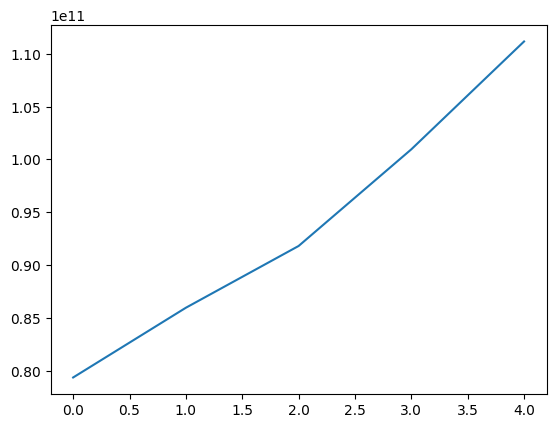

In [15]:
trde_passenger_df.deminit_trde_private_and_public_passenger_km.plot()

<Axes: >

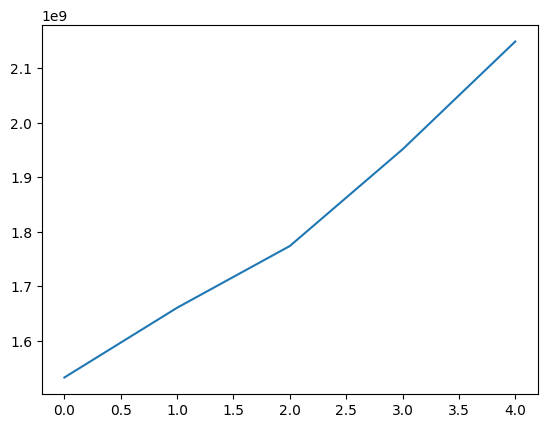

In [16]:
trde_passenger_df.deminit_trde_regional_passenger_km.plot()

In [17]:
trde_passenger_df["deminit_trde_private_and_public_per_capita_passenger_km"] = trde_passenger_df["deminit_trde_private_and_public_passenger_km"] / trde_passenger_df["pop_total"]
trde_passenger_df["deminit_trde_regional_per_capita_passenger_km"] = trde_passenger_df["deminit_trde_regional_passenger_km"] / trde_passenger_df["pop_total"]

In [18]:
# Keep only deminit columns and year columns
trde_passenger_df = trde_passenger_df[["year", "deminit_trde_private_and_public_per_capita_passenger_km", 
         "deminit_trde_regional_per_capita_passenger_km"]]

In [19]:
trde_passenger_df.head()

,year,deminit_trde_private_and_public_per_capita_passenger_km,deminit_trde_regional_per_capita_passenger_km
0,2015,2245.495980,43.393178
1,2016,2352.897913,45.468671
2,2017,2426.772259,46.896259
3,2018,2579.635329,49.850267
4,2019,2745.852607,53.062340


In [20]:
trde_passenger_df.tail()

,year,deminit_trde_private_and_public_per_capita_passenger_km,deminit_trde_regional_per_capita_passenger_km
0,2015,2245.495980,43.393178
1,2016,2352.897913,45.468671
2,2017,2426.772259,46.896259
3,2018,2579.635329,49.850267
4,2019,2745.852607,53.062340


In [21]:
trde_passenger_df_extended = gu.extend_projection(trde_passenger_df, base_year + 1, 2100)
trde_passenger_df_extended


,year,deminit_trde_private_and_public_per_capita_passenger_km,deminit_trde_regional_per_capita_passenger_km
0,2015,2245.495980,43.393178
1,2016,2352.897913,45.468671
2,2017,2426.772259,46.896259
3,2018,2579.635329,49.850267
4,2019,2745.852607,53.062340
...,...,...,...
81,2096,2745.852607,53.062340
82,2097,2745.852607,53.062340
83,2098,2745.852607,53.062340
84,2099,2745.852607,53.062340


## Validation

In [22]:
# Check for duplicates
gu.check_duplicates(trde_passenger_df_extended)

No duplicated years found in the DataFrame.
No duplicated rows found in the DataFrame.


In [23]:
og_df = pd.read_csv(os.path.join(INPUT_DATA_DIR_PATH, "sisepuede_raw_global_inputs_uganda.csv"))
og_df = og_df[["deminit_trde_private_and_public_per_capita_passenger_km", 
         "deminit_trde_regional_per_capita_passenger_km"]]
og_df.head()

,deminit_trde_private_and_public_per_capita_passenger_km,deminit_trde_regional_per_capita_passenger_km
0,90.416780,13.224175
1,90.835038,13.124486
2,90.835038,13.124486
3,90.835038,13.124486
4,90.835038,13.124486


<Axes: >

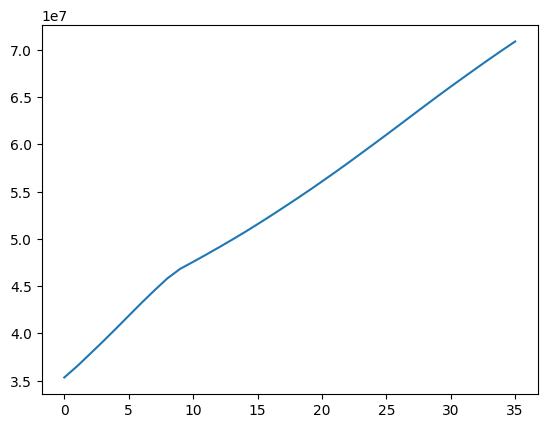

In [24]:
pop_df["pop_total"].plot()

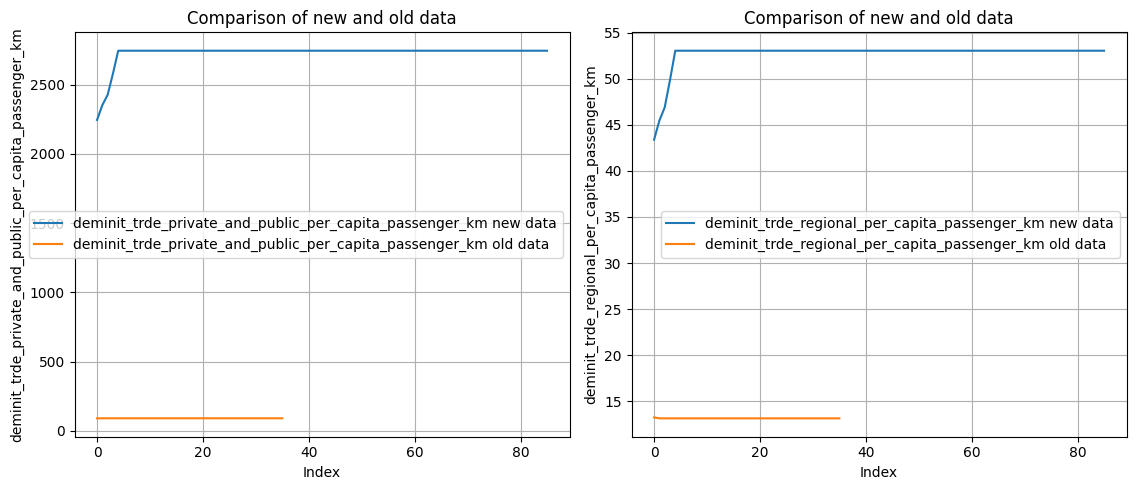

In [25]:
edau.compare_variables(trde_passenger_df_extended,
                       og_df,
                       ["deminit_trde_private_and_public_per_capita_passenger_km",
                        "deminit_trde_regional_per_capita_passenger_km"]
                        )

In [26]:
trde_passenger_df_extended.to_csv(os.path.join(OUTPUT_DATA_DIR_PATH, "deminit_trde_per_capita_passenger_km.csv"), index=False)